<h1 style="text-align: center; font-weight: bold;">Narges Mohammadi Elyasi </h1>
<h1 style="text-align: center"> 810100258</h1>
<h1 style="text-align: center;">CA3 - Clustering</h1>

# Problem Description
In this project, we intend to analyze images of various flowers using `K-Means` and `DB-SCAN` method and test the trained model. Our goal is to categorize these images into different clusters based on the data we have available. The aim is to ensure that after applying the clustering algorithm, each flower image is placed in the most appropriate cluster possible.


In [82]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, homogeneity_score
import seaborn as sns
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess


## Q1:Feature extraction using pre-trained CNNs like VGG16 offers:
1. Dimensionality reduction for efficient processing.
2. Abstraction of complex visual features.
3. Leveraging pre-trained knowledge for tasks, improving performance and efficiency compared to raw pixel data.


## Q2:Conduct research on feature extraction from images and provide a concise explanation of three techniques.

While reading individual pixels is a low-level feature, high-level features include edges, corners, textures, and complex shapes. Extracting these features allows us to create more meaningful representations for further analysis and processing.

Here are three common techniques for image feature extraction:

1. **Canny Edge Detection**:
   - **Objective**: Detect edges in an image.
   - **How It Works**: Canny edge detection identifies pixels where there is an abrupt change in color intensity (gradient). These abrupt changes correspond to edges. Noise is filtered out during this process.
   - **Application**: Useful for tasks like object boundary detection and image segmentation.
   - **Example**: Imagine finding the edges of a photograph, highlighting the contours of objects.

2. **Harris Corner Detection**:
   - **Objective**: Identify corners (distinctive points) in an image.
   - **How It Works**: The Harris corner detector analyzes local intensity variations. Corners are points where the intensity changes significantly in multiple directions.
   - **Application**: Used for feature-based image matching, tracking, and 3D reconstruction.
   - **Example**: Think of identifying the corners of a building facade or the intersection points of roads in a map.

3. **Other Techniques**:
   - **SIFT (Scale-Invariant Feature Transform)**: Detects key points invariant to scale changes, rotations, and affine transformations. Widely used in object recognition and image stitching.
   - **SURF (Speeded-Up Robust Features)**: Similar to SIFT but computationally faster. Also used for feature matching and object tracking.
   - **ORB (Oriented FAST and Rotated BRIEF)**: Combines speed and accuracy for feature extraction. Suitable for real-time applications.



## Q3:What three pre-processing steps should be performed on images before they are fed into a model?

**Rescaling**:
Objective: Normalize pixel values to a consistent range.
How It Works: Divide pixel values by 255 to scale them between 0 and 1.
Why: Ensures uniform input for neural networks.

**Resize**:
Objective: Ensure all images have the same dimensions.
How It Works: Resize images to a fixed size (e.g., 224x224 pixels).
Why: VGG16 expects consistent input dimensions.



In [83]:
folder_path = r"/content/drive/MyDrive/flower_images/flower_images"
csv_name = "flower_labels.csv"

In [84]:
def read_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:
                img_resized = cv2.resize(img, target_size)
                img_augmented = datagen.random_transform(img_resized)
                img_preprocessed = vgg16_preprocess(img_augmented)
                images.append(img_preprocessed)

    return np.array(images, dtype=np.float32)

In [85]:
def display_images(images, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(np.clip(images[i], 0, 1))
        plt.axis('off')
    plt.show()


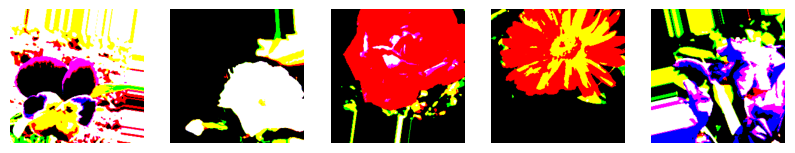

In [113]:
images = read_and_preprocess_images(folder_path)
display_images(images)

In [87]:
base_model = VGG16(weights="imagenet", include_top=False)
features = base_model.predict(images)

7/7 [==============================] - 153s 20s/step


In [114]:
labels_df = pd.read_csv(folder_path+'/'+csv_name)
true_labels = labels_df['label']

## Q4: K-Means and DBSCAN: Overview, Advantages, and Disadvantages

### K-Means Clustering
K-Means is a partitioning method that divides the data into K clusters. It assigns points to the nearest cluster center and recalculates the centers until convergence.
- **Advantages:**
  - **Efficiency:** Fast and efficient for large datasets.
  - **Ease of Implementation:** Relatively simple to understand and implement.
  - **Well-defined Clusters:** Produces tight clusters with a clear centroid.
- **Disadvantages:**
  - **Number of Clusters:** Requires specifying the number of clusters (K) in advance.
  - **Sensitivity to Initialization:** Results can vary based on initial cluster centers.
  - **Shape Limitation:** Assumes spherical cluster shapes, which may not fit all datasets.
  - **Outliers Impact:** Sensitive to noise and outliers.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN clusters points based on density. Core points have many neighbors within a given radius, border points have fewer neighbors, and noise points are outliers.
- **Advantages:**
  - **No Need for K:** Automatically determines the number of clusters.
  - **Flexibility in Cluster Shapes:** Can find arbitrarily shaped clusters.
  - **Robust to Outliers:** Outliers do not heavily influence the clusters.
  - **Minimal Parameters:** Requires only two parameters (neighborhood size and minimum points).
- **Disadvantages:**
  - **Density Variation:** Struggles with varying densities across clusters.
  - **Parameter Sensitivity:** Choosing the right parameters can be challenging.
  - **Higher Computational Cost:** Can be computationally more expensive than K-means, especially on large datasets.



In [115]:
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=30)
    kmeans.fit(features.reshape(features.shape[0], -1))
    inertia_values.append(kmeans.inertia_)


## Q5:What method did you use to find the optimal K in the K-Means method? Explain.

**Objective**: Find the point where the Within-Cluster-Sum of Squared Errors (WSS) starts diminishing significantly.
**How It Works**:
Calculate the WSS for different values of k (number of clusters).
Look for an “elbow” point in the plot of WSS versus k.
The elbow represents the optimal k where adding more clusters does not significantly reduce WSS.
**Example**:
Imagine a plot where WSS decreases as k increases. The elbow point indicates the optimal k value.

In [100]:
kl = KneeLocator(range(1, 11), inertia_values, curve="convex", direction="decreasing")
optimal_k = kl.elbow


In [101]:
def plot_elbow_method(inertia_values, optimal_k):
    K = range(1, len(inertia_values) + 1)
    plt.plot(K, inertia_values, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.axvline(x=optimal_k, color='r', linestyle='--', linewidth=1)
    plt.text(optimal_k + 0.1, max(inertia_values) * 0.9, f'Optimal k={optimal_k}', color='r')
    plt.show()


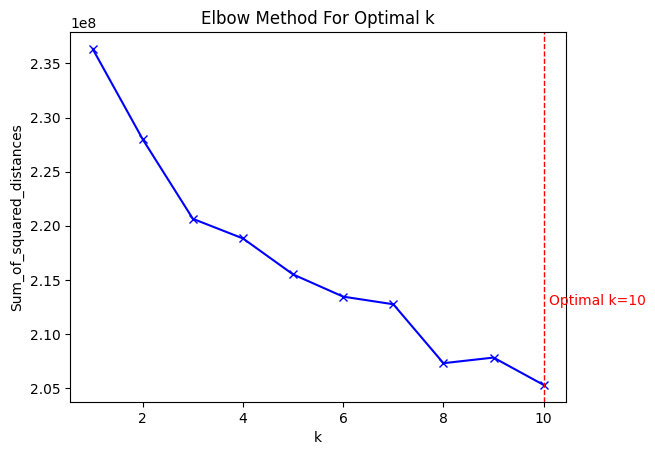

In [102]:
plot_elbow_method(inertia_values, optimal_k)

In [103]:
kmeans = KMeans(n_clusters=optimal_k, random_state=100,n_init=10)
kmeans.fit(features.reshape(features.shape[0], -1))
y_kmeans = kmeans.predict(features.reshape(features.shape[0], -1))


In [94]:
centers = np.array(kmeans.cluster_centers_)
centroid = pd.DataFrame(centers)

## Q6:Compare the Outputs of Two Types of Clustering

1. **Nature of Clusters**:
    - **DBSCAN**: It's designed to identify clusters of arbitrary shapes based on density. It groups together closely packed points and identifies outliers as noise.
    - **K-means**: It partitions data into K clusters where each data point belongs to the cluster with the nearest mean. It works based on the concept of centroids and minimizes the within-cluster variance.

2. **Cluster Assignment**:
    - **DBSCAN**: Assigns each data point to a cluster, labels outliers as noise, and doesn't require specifying the number of clusters beforehand.
    - **K-means**: Assigns each data point to the nearest cluster centroid, requiring the number of clusters (K) to be predefined.

3. **Scalability**:
    - **DBSCAN**: Generally scales well with large datasets due to its density-based nature.
    - **K-means**: Can suffer from scalability issues, particularly with large datasets, as it involves iterative computation over all data points.

4. **Parameter Sensitivity**:
    - **DBSCAN**: Requires tuning of two parameters: epsilon (ε) and minPts (minimum number of points required to form a dense region).
    - **K-means**: Sensitive to the initial placement of cluster centroids and the choice of K.

5. **Output Representation**:
    - **DBSCAN**: Outputs clusters with varying densities and can handle noise points. Each cluster is represented as a set of points.
    - **K-means**: Outputs clusters with roughly equal variance and size, represented by their centroids.

6. **Handling Noise**:
    - **DBSCAN**: Can identify and handle noise explicitly as separate from clusters.
    - **K-means**: Sensitive to noise and outliers, which can significantly affect cluster centroids.

DBSCAN is often favored when dealing with arbitrary-shaped clusters and noise detection, while K-means is popular for its simplicity and efficiency when the number of clusters is known and data is well-separated.

In [95]:
cluster_labels = kmeans.labels_
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features.reshape(features.shape[0], -1))
pca_centers = pca.transform(centers)


In [104]:
def plot_clusters(features, centers, optimal_k, clustering_type):
    plt.figure(figsize=(10, 8))
    for cluster_id in range(optimal_k):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        plt.scatter(features[cluster_indices, 0], features[cluster_indices, 1], label=f'Cluster {cluster_id}')

    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=100, label='Centroids')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

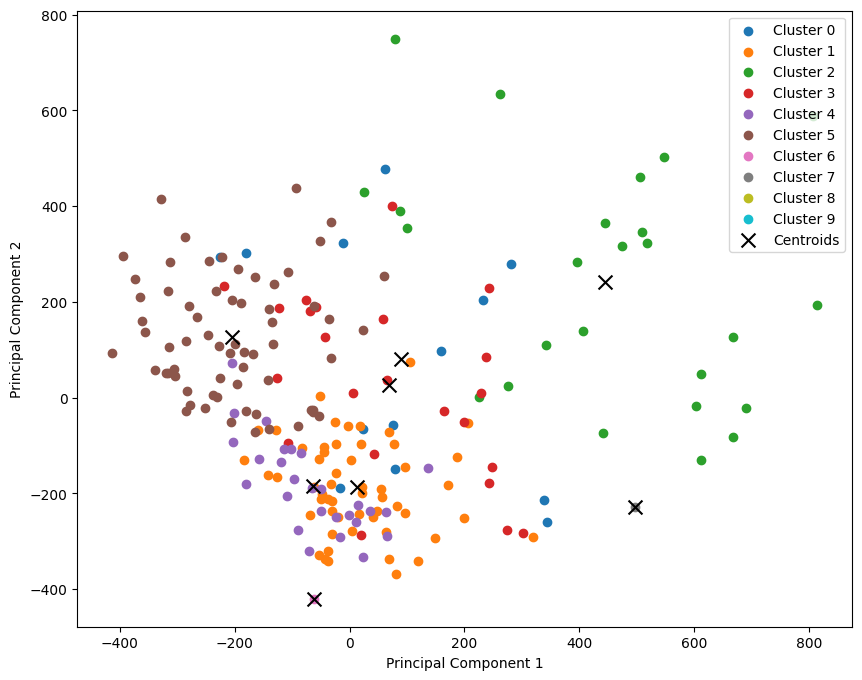

In [105]:
plot_clusters(pca_features, pca_centers, optimal_k, 'k-means')

In [106]:

silhouette = silhouette_score(features.reshape(features.shape[0], -1), cluster_labels)
print("Silhouette Score for k_means:", silhouette)

homogeneity = homogeneity_score(true_labels, cluster_labels)
print("Homogeneity Score for k_means:", homogeneity)

Silhouette Score for k_means: -0.014459188
Homogeneity Score fro k_means: 0.045036323565402554


In [107]:
n_samples,height,width,channels=features.shape
features_reshaped=features.reshape((n_samples,height*width*channels))

In [109]:
db_scan = DBSCAN(eps = 80,min_samples = 2)
db_labels = db_scan.fit_predict(pca_features)


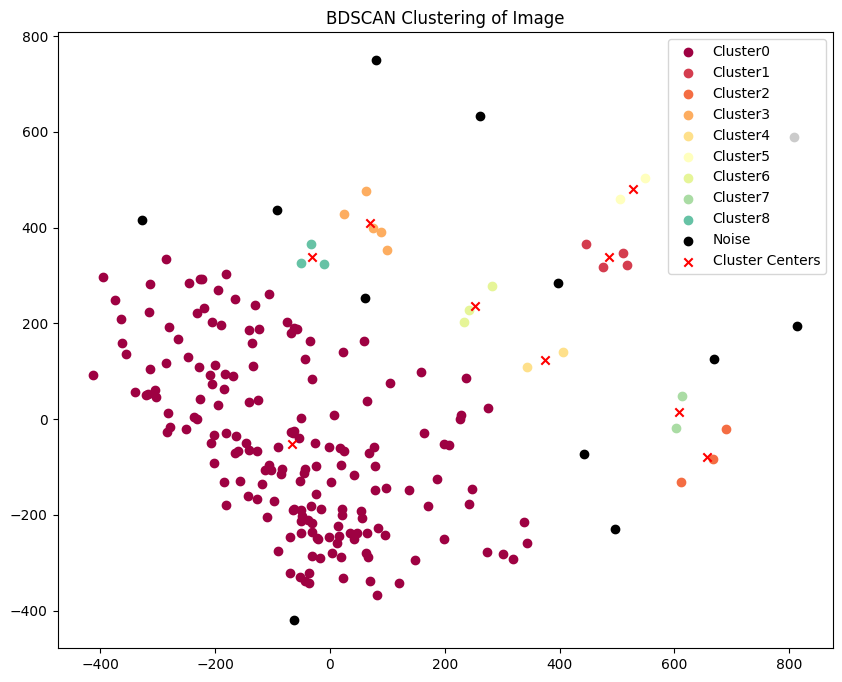

In [110]:
cluster_names = {label: f'Cluster{label}' for label in set(db_labels) if label != -1}
cluster_names[-1] = 'Noise'
plt.figure(figsize=(10, 8))
for label in set(db_labels):
  if label == -1:
    color = [0,0,0,1]
  else:
    color = plt.cm.Spectral(label/len(cluster_names))

  cluster_points = pca_features[db_labels==label]
  plt.scatter(cluster_points[:,0],cluster_points[:,1],color=color,label = cluster_names[label])

cluster_centers = np.array([np.mean(pca_features[db_labels==label],axis =0 ) for label in set(db_labels) if label != -1])

plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker = 'x',color = 'red',label='Cluster Centers')
plt.title('BDSCAN Clustering of Image')
plt.legend()
plt.show()

In [116]:
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"Number of clusters for DBSCAN: {n_clusters}")


Number of clusters for DBSCAN: 9


In [112]:

silhouette = silhouette_score(features.reshape(features.shape[0], -1), db_labels)
print("Silhouette Score for DBSCAN:", silhouette)

homogeneity = homogeneity_score(true_labels, db_labels)
print("Homogeneity Score for DBSCAN:", homogeneity)

Silhouette Score for DBSCAN: -0.052459136
Homogeneity Score for DBSCAN: 0.0870898516997062


## Q7: Explain what is PCA.

Principal Component Analysis (PCA) is a statistical technique used in data analysis for dimensionality reduction while preserving as much variance as possible.

### How PCA Works
1. **Standardization:** The first step often involves standardizing the data (scaling each feature to have zero mean and unit variance).
2. **Covariance Matrix Computation:** PCA computes the covariance matrix to understand how variables in the data are varying with respect to each other.
3. **Eigenvalue Decomposition:** The covariance matrix is decomposed into eigenvalues and eigenvectors. Eigenvectors represent directions of maximum variance, and eigenvalues represent the magnitude of these directions.
4. **Principal Components Selection:** Eigenvectors are sorted by their eigenvalues in descending order. The top eigenvectors are selected as principal components. These components are the new, reduced features of the dataset.
5. **Data Transformation:** The original data is transformed into this new subspace with reduced dimensions.

### Key Points
- **Dimensionality Reduction:** PCA reduces the number of features while retaining the most significant variance in the data.
- **Visualization:** Helps in visualizing high-dimensional data in a lower-dimensional space.
- **Noise Reduction:** By eliminating components with lower variance, PCA can help in noise reduction.

### Conclusion
PCA is an essential tool for feature extraction and dimensionality reduction, particularly useful in exploratory data analysis and in improving the efficiency of machine learning models on high-dimensional data.


## Q8: Explain how to calculate silhouette and homogeneity criteria.

### Silhouette Score
The Silhouette Score is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

#### Calculation Steps:
1. **Compute a(i):** For each point, calculate the average distance from all other points in the same cluster (intra-cluster distance).
2. **Compute b(i):** For the same point, calculate the average distance from all points in the nearest cluster that the point is not a part of (nearest-cluster distance).
3. **Silhouette Score for a Point:** The Silhouette Score \( S(i) \) for each point is then given by:
   $$ S(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}} $$
4. **Overall Silhouette Score:** The overall score is the average of the Silhouette Scores for all points.

### Homogeneity Score
Homogeneity Score measures if each cluster contains only members of a single class.

#### Calculation Steps:
1. **Cluster Labels and True Labels:** Consider the cluster labels assigned by the algorithm and the true labels of the data.
2. **Compute Homogeneity:** Calculate how much of each cluster is dedicated to the most common class in that cluster. The formula is:
   $$ H = 1 - \frac{H(C|K)}{H(C)} $$
   where \( H(C|K) \) is the conditional entropy of the class distribution given the cluster assignment and \( H(C) \) is the entropy of the class distribution.
3. **Interpretation:** A score of 1 means perfect homogeneity, whereas a score close to 0 means low homogeneity.

### Conclusion
The Silhouette Score provides a measure of how well each object lies within its cluster, and the Homogeneity Score quantifies whether each cluster is composed of a single class. Both are crucial for evaluating the performance of clustering algorithms.



## Q9:Report the results obtained from the mentioned criteria for each of the methods.
Based on the evaluation metrics, k-means clustering yielded better results compared to DBSCAN for our dataset. The clusters produced by k-means were more internally coherent and uniform in their composition. However, it's essential to consider other factors such as the nature of the data and computational requirements when selecting the appropriate clustering algorithm for a specific task.

## Q10: Suggest ways to improve the performance of the models.
- Optimzing Parameters in each method
- Better preprocessing
- Using better feature extracting models better than doc2vec